In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.stats.diagnostic import acorr_ljungbox
from sklearn.metrics import mean_absolute_error, mean_squared_error
import pickle
import warnings

# Suppress warnings for cleaner output
warnings.filterwarnings("ignore")

# Set plot style for consistency
sns.set_context("notebook", font_scale=1.2)

In [2]:
# Load the cleaned dataset
try:
    df = pd.read_csv("Prices_Cleaned.csv")
    df["date"] = pd.to_datetime(df["date"], errors="coerce")
    print("Dataset loaded successfully!")
    print("Dataset shape:", df.shape)
except FileNotFoundError:
    print("Error: 'Prices_Cleaned.csv' file not found. Please ensure the file is in the correct directory.")
    exit()
except ValueError as e:
    print(f"Error in data parsing: {e}")
    exit()

Dataset loaded successfully!
Dataset shape: (851264, 10)


In [24]:
df

,date,symbol,open,close,low,high,volume,price_range,daily_return,avg_price
0,2016-01-05,WLTW,123.430000,125.839996,122.309998,126.250000,2163600.0,3.940002,0.019525,124.799998
1,2016-01-06,WLTW,125.239998,119.980003,119.940002,125.540001,2386400.0,5.599999,-0.041999,121.820002
2,2016-01-07,WLTW,116.379997,114.949997,114.930000,119.739998,2489500.0,4.809998,-0.012287,116.539998
3,2016-01-08,WLTW,115.480003,116.620003,113.500000,117.440002,2006300.0,3.940002,0.009872,115.853335
4,2016-01-11,WLTW,117.010002,114.970001,114.089996,117.330002,1408600.0,3.240006,-0.017434,115.463333
...,...,...,...,...,...,...,...,...,...,...
851259,2016-12-30,ZBH,103.309998,103.199997,102.849998,103.930000,973800.0,1.080002,-0.001065,103.326665
851260,2016-12-30,ZION,43.070000,43.040001,42.689999,43.310001,1938100.0,0.620002,-0.000697,43.013334
851261,2016-12-30,ZTS,53.639999,53.529999,53.270000,53.740002,1701200.0,0.470002,-0.002051,53.513334
851262,2016-12-30,AIV,44.730000,45.450001,44.410000,45.590000,1380900.0,1.180000,0.016097,45.150000


In [3]:
# Check available columns
print("\nAvailable columns:", df.columns.tolist())


Available columns: ['date', 'symbol', 'open', 'close', 'low', 'high', 'volume', 'price_range', 'daily_return', 'avg_price']


In [4]:
# Select ticker symbol and prepare data
ticker_symbol = "AAPL"
if 'symbol' not in df.columns:
    print(f"Warning: 'symbol' column not found. Assuming single stock data for {ticker_symbol}.")
    sample_df = df.copy()
else:
    sample_df = df[df['symbol'] == ticker_symbol].copy()
    if sample_df.empty:
        print(f"Error: No data found for ticker {ticker_symbol}.")
        exit()

In [5]:
# Sort and set date as index
sample_df = sample_df.sort_values("date")
sample_df.set_index("date", inplace=True)

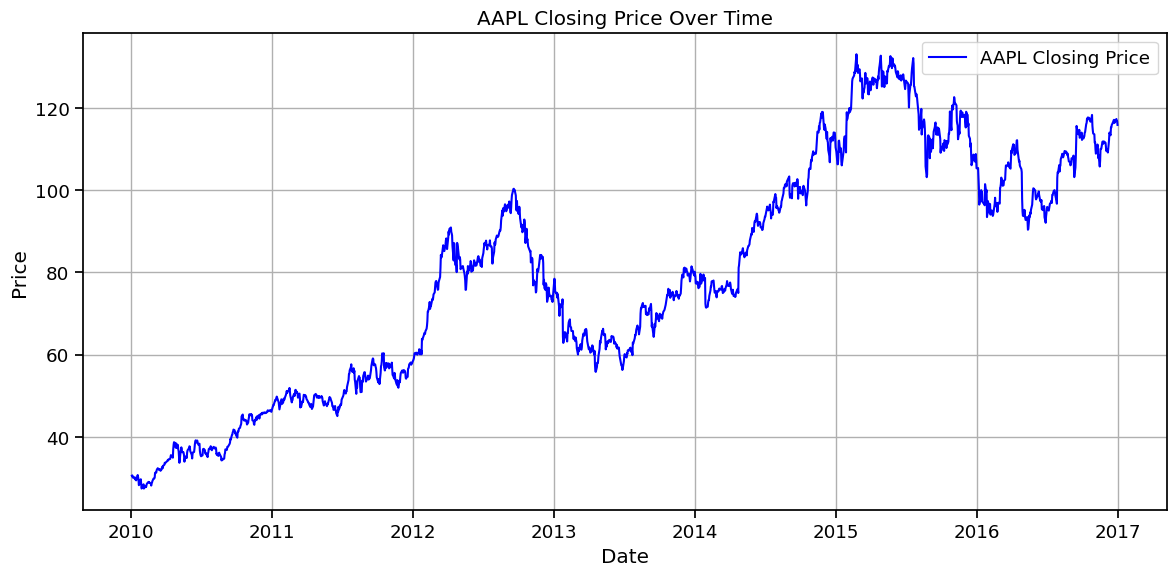

In [6]:
# Plot closing price
plt.figure(figsize=(12, 6))
plt.plot(sample_df["close"], label=f"{ticker_symbol} Closing Price", color="blue")
plt.title(f"{ticker_symbol} Closing Price Over Time")
plt.xlabel("Date")
plt.ylabel("Price")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

In [7]:
# Stationarity test (ADF) on last 180 days
sample_df_short = sample_df.last('180D')
adf_result = adfuller(sample_df_short["close"], maxlag=5)
print("\nStationarity Test (Augmented Dickey-Fuller):")
print(f"ADF Statistic: {adf_result[0]:.4f}")
print(f"p-value: {adf_result[1]:.4f}")
if adf_result[1] <= 0.05:
    print("✅ The series is stationary.")
    d = 0
else:
    print("❌ The series is non-stationary, differencing will be applied.")
    d = 1


Stationarity Test (Augmented Dickey-Fuller):
ADF Statistic: -2.3178
p-value: 0.1663
❌ The series is non-stationary, differencing will be applied.


In [8]:
# Prepare series for modeling
if d == 1:
    ts_to_model = sample_df["close"].diff().dropna()
    title_diff = f"{ticker_symbol} First Order Differenced Series"
else:
    ts_to_model = sample_df["close"]
    title_diff = f"{ticker_symbol} Original Series (Stationary)"

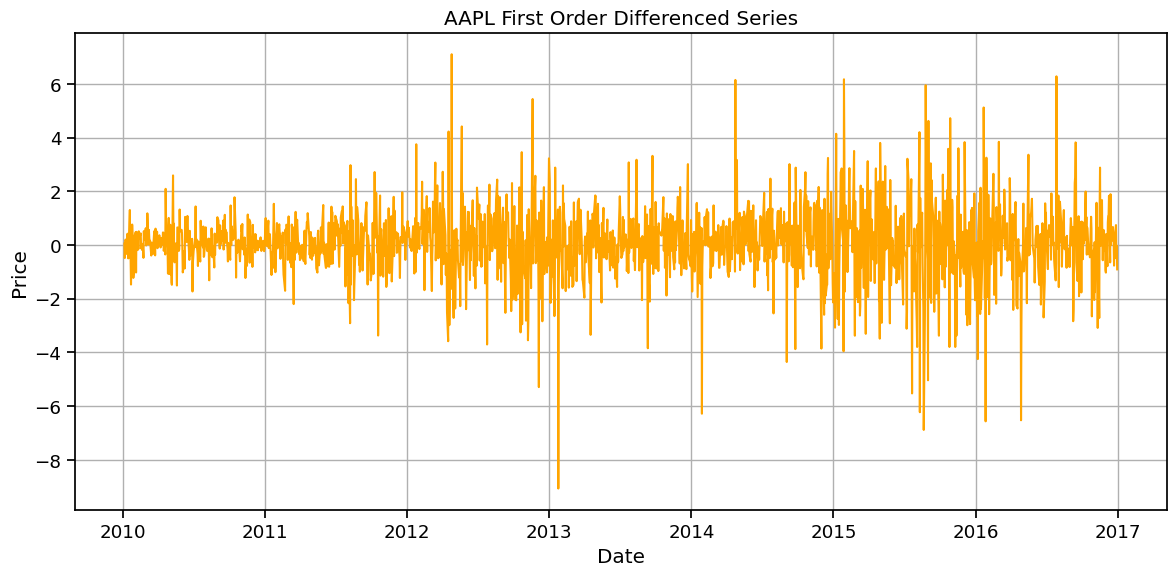

In [9]:
# Plot the series to model
plt.figure(figsize=(12, 6))
plt.plot(ts_to_model, color='orange')
plt.title(title_diff)
plt.xlabel("Date")
plt.ylabel("Price")
plt.grid(True)
plt.tight_layout()
plt.show()

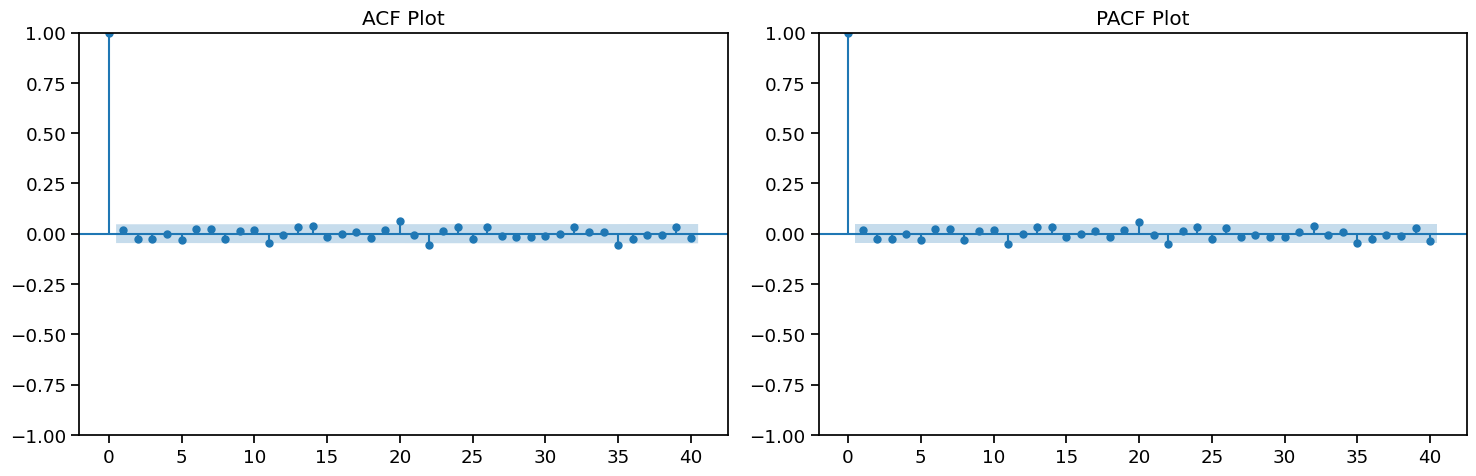

In [10]:
# Plot ACF and PACF
fig, axes = plt.subplots(1, 2, figsize=(15, 5))
plot_acf(ts_to_model, ax=axes[0], lags=40)
axes[0].set_title("ACF Plot")
plot_pacf(ts_to_model, ax=axes[1], lags=40, method='ywm')
axes[1].set_title("PACF Plot")
plt.tight_layout()
plt.show()

In [11]:
# Split data into train and test sets (last 30 days for testing)
test_size = 30
train_data = sample_df["close"].iloc[:-test_size]
test_data = sample_df["close"].iloc[-test_size:]

In [12]:
# Fit ARIMA model
p, q = 5, 2
try:
    model = ARIMA(train_data, order=(p, d, q))
    model_fit = model.fit()
    print("\nARIMA Model Summary:")
    print(model_fit.summary())
except ValueError as e:
    print(f"Error fitting ARIMA model: {e}")
    exit()


ARIMA Model Summary:
                               SARIMAX Results                                
Dep. Variable:                  close   No. Observations:                 1732
Model:                 ARIMA(5, 1, 2)   Log Likelihood               -2961.765
Date:                Sat, 17 May 2025   AIC                           5939.530
Time:                        21:29:26   BIC                           5983.182
Sample:                             0   HQIC                          5955.676
                               - 1732                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.5830      0.023    -25.396      0.000      -0.628      -0.538
ar.L2         -0.9769      0.026    -37.838      0.000      -1.028      -0.926
ar.L3         -0.0195      0.0

In [13]:
# Save the trained model
try:
    with open("arima_model.pkl", "wb") as f:
        pickle.dump(model_fit, f)
    print("Model saved successfully to 'arima_model.pkl'.")
except Exception as e:
    print(f"Error saving model: {e}")

Model saved successfully to 'arima_model.pkl'.


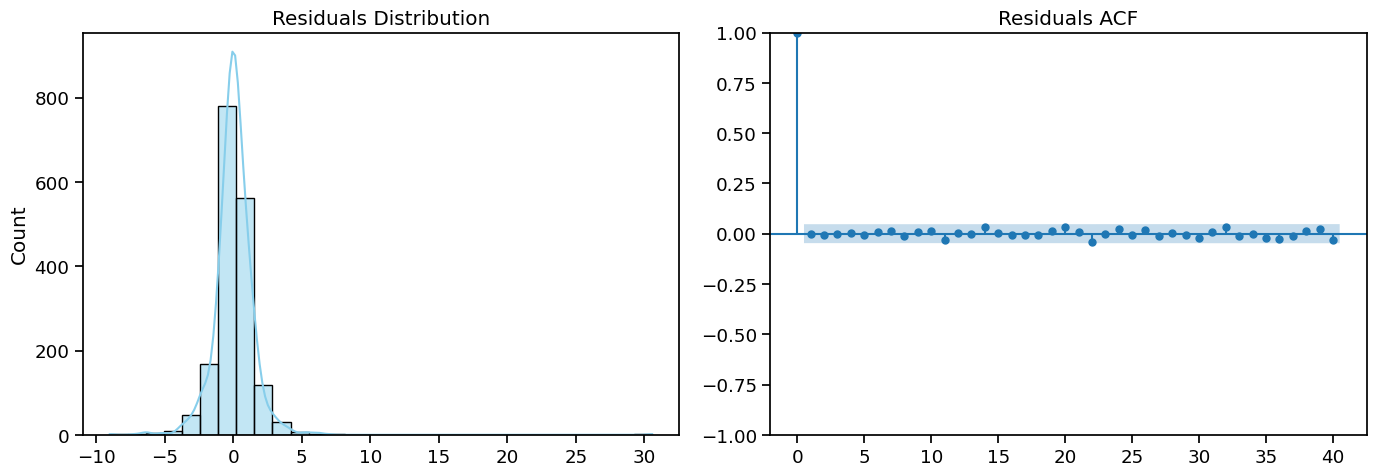

In [15]:
# Residual diagnostics
residuals = model_fit.resid
fig, axes = plt.subplots(1, 2, figsize=(14, 5))
sns.histplot(residuals, bins=30, kde=True, ax=axes[0], color="skyblue")
axes[0].set_title("Residuals Distribution")
plot_acf(residuals, ax=axes[1], lags=40)
axes[1].set_title("Residuals ACF")
plt.tight_layout()
plt.show()

In [16]:
# Ljung-Box test for residual autocorrelation
ljung_box_result = acorr_ljungbox(residuals, lags=[10], return_df=True)
print(f"\nLjung-Box Test p-value: {ljung_box_result['lb_pvalue'].values[0]:.4f}")
if ljung_box_result['lb_pvalue'].values[0] > 0.05:
    print("✅ Residuals show no significant autocorrelation.")
else:
    print("❌ Residuals may have autocorrelation. Consider adjusting model parameters.")


Ljung-Box Test p-value: 0.9998
✅ Residuals show no significant autocorrelation.


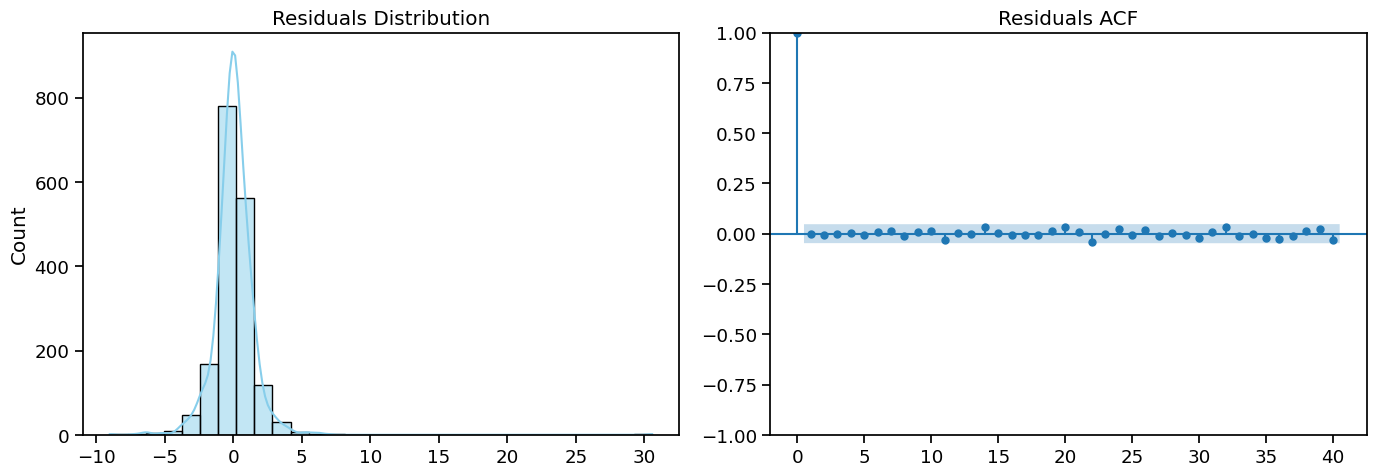

In [17]:
# Residual diagnostics
residuals = model_fit.resid
fig, axes = plt.subplots(1, 2, figsize=(14, 5))
sns.histplot(residuals, bins=30, kde=True, ax=axes[0], color="skyblue")
axes[0].set_title("Residuals Distribution")
plot_acf(residuals, ax=axes[1], lags=40)
axes[1].set_title("Residuals ACF")
plt.tight_layout()
plt.show()

In [18]:
# Ljung-Box test for residual autocorrelation
ljung_box_result = acorr_ljungbox(residuals, lags=[10], return_df=True)
print(f"\nLjung-Box Test p-value: {ljung_box_result['lb_pvalue'].values[0]:.4f}")
if ljung_box_result['lb_pvalue'].values[0] > 0.05:
    print("✅ Residuals show no significant autocorrelation.")
else:
    print("❌ Residuals may have autocorrelation. Consider adjusting model parameters.")


Ljung-Box Test p-value: 0.9998
✅ Residuals show no significant autocorrelation.


In [19]:
# Forecast for test period
forecast = model_fit.get_forecast(steps=test_size)
forecast_df = forecast.summary_frame()
forecast_index = test_data.index
forecast_df["date"] = forecast_index
forecast_df.set_index("date", inplace=True)

In [20]:
# Calculate performance metrics
y_true = test_data
y_pred = forecast_df["mean"]
mae = mean_absolute_error(y_true, y_pred)
rmse = np.sqrt(mean_squared_error(y_true, y_pred))
mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100

print("\nModel Performance Metrics:")
print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
print(f"Mean Absolute Percentage Error (MAPE): {mape:.2f}%")


Model Performance Metrics:
Mean Absolute Error (MAE): 3.5838
Root Mean Squared Error (RMSE): 4.4793
Mean Absolute Percentage Error (MAPE): 3.11%


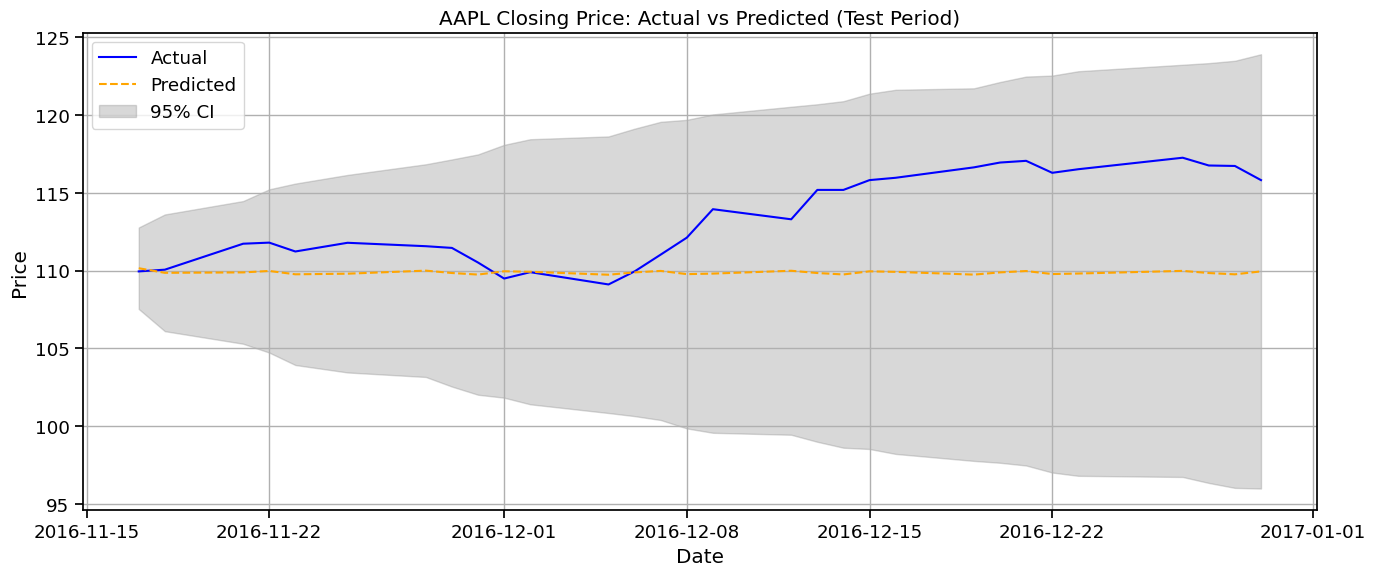

In [21]:
# Plot test data vs predictions
plt.figure(figsize=(14, 6))
plt.plot(test_data, label="Actual", color='blue')
plt.plot(forecast_df["mean"], label="Predicted", linestyle="--", color='orange')
plt.fill_between(forecast_df.index, forecast_df["mean_ci_lower"], forecast_df["mean_ci_upper"], 
                 color="gray", alpha=0.3, label="95% CI")
plt.title(f"{ticker_symbol} Closing Price: Actual vs Predicted (Test Period)")
plt.xlabel("Date")
plt.ylabel("Price")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [22]:
# Forecast next 30 days (future)
forecast_steps = 30
future_forecast = model_fit.get_forecast(steps=forecast_steps)
future_forecast_index = pd.date_range(start=sample_df.index.max() + pd.Timedelta(days=1), periods=forecast_steps)
future_forecast_df = future_forecast.summary_frame()
future_forecast_df["date"] = future_forecast_index
future_forecast_df.set_index("date", inplace=True)

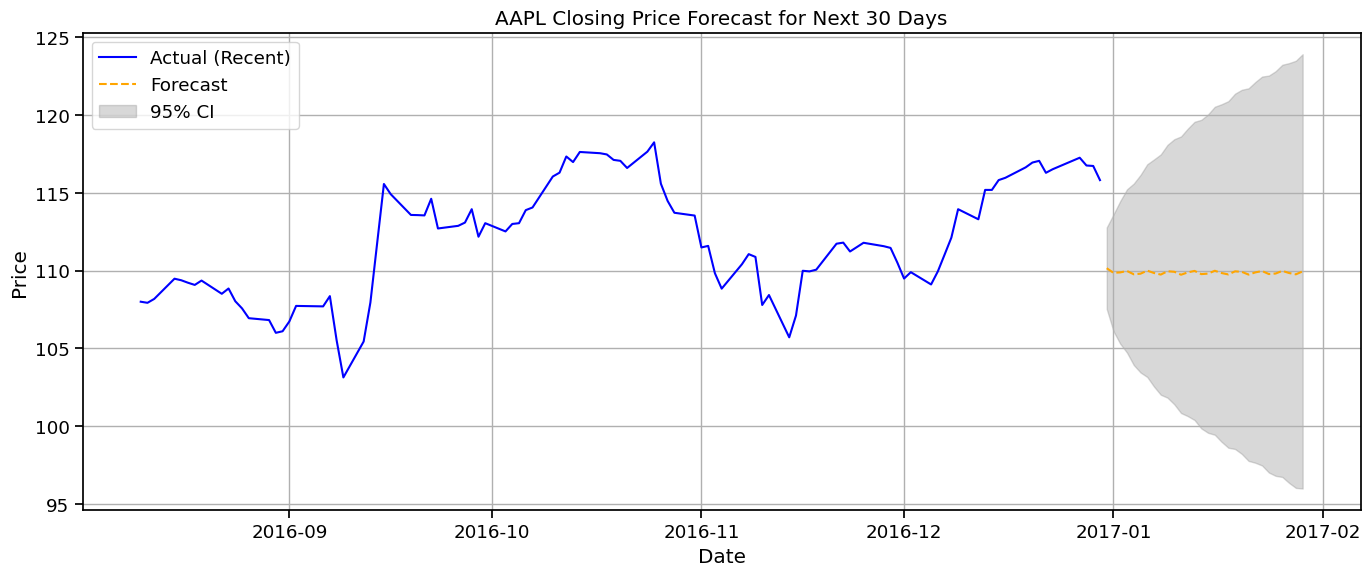

In [23]:
# Plot future forecast with recent actual data
plt.figure(figsize=(14, 6))
plt.plot(sample_df["close"].iloc[-100:], label="Actual (Recent)", color='blue')
plt.plot(future_forecast_df["mean"], label="Forecast", linestyle="--", color='orange')
plt.fill_between(future_forecast_df.index, future_forecast_df["mean_ci_lower"], 
                 future_forecast_df["mean_ci_upper"], color="gray", alpha=0.3, label="95% CI")
plt.title(f"{ticker_symbol} Closing Price Forecast for Next {forecast_steps} Days")
plt.xlabel("Date")
plt.ylabel("Price")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()